# 너와 나의 연결다리

## 합정역 ~ 강변역 퇴근시간 승하차 인원 수 예측하기

### 고려사항
- 날씨 (강우량에 따라, 고온, 추위, 적설량)
- 이벤트 (지하철 파업, 신년행사/광화문, 여러 빅이벤트)
- 기본적인 직장 분포도
- 지하철역 주변 버스 정류장 상관도
- 날짜, 계절, 분기별 승하차 분포도 (공휴일, 연휴), 특히 불금(신촌, 홍대입구행 인원 급증 하는 듯) / 느낌은 월 ~ 수 강변행 인원수가 많아지는 것 같고, 목은 전체적으로 퇴근시간 지하철 승차자 수가 적어지는 것 같고, 금요일에는 확실히 홍대입구 행 인원수가 급증

- 이화여대 석사 학위 논문에는 13, 14년 2개년 데이터를 활용하였다.
- 17,18년 일별 승하차 인원수는 구할 수 있으나 19년 데이터는 아직 업데이트 안됨. 그래서 17, 18년으로 이용하되 19년 월별 데이터는 존재하므로 상관도에 있어서 문제가 없다는 점만 확인 후 19년은 스킵해야 할 듯
- 환승역 같은 경우 하나의 호선만 있는 것이 아니라 하나의 역에 여러 호선이 존재한다. ex) 시청역 - 1, 2호선 이렇게 같이 존재


In [5]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pylab as plt

import seaborn as sns
sns.set()

In [6]:
subway_2018 = pd.read_excel('../project_data/subway/seoul_2018_data.xlsx', encoding='euc-kr')

In [7]:
subway_2017 = pd.read_excel('../project_data/subway/seoul_2017_data.xlsx', encoding='euc-kr')

In [9]:
subway_month = pd.read_csv('../project_data/subway/seoul_subway_month_data.csv', encoding='euc-kr')

## 2018년

In [10]:
subway_2018 = subway_2018.rename(columns=subway_2018.iloc[0])
subway_2018 = subway_2018.drop(0)

In [11]:
subway_2018.head()

,날짜,호선,역번호,역명,구분,05 ~ 06,06 ~ 07,07 ~ 08,08 ~ 09,09 ~ 10,...,16 ~ 17,17 ~ 18,18 ~ 19,19 ~ 20,20 ~ 21,21 ~ 22,22 ~ 23,23 ~ 24,00 ~ 01,합 계
1,2018-01-01 00:00:00,1호선,150,서울역,승차,373,318,365,785,1047,...,3476,3891,3227,2945,2382,3070,1750,781,96,40393
2,2018-01-01 00:00:00,1호선,150,서울역,하차,205,1040,872,984,1650,...,2885,2845,2337,2131,1669,1404,868,477,147,34730
3,2018-01-01 00:00:00,1호선,151,시청,승차,87,105,124,197,291,...,1027,1102,1278,1163,1032,975,553,214,9,12298
4,2018-01-01 00:00:00,1호선,151,시청,하차,47,294,497,1017,673,...,781,702,552,388,308,236,160,100,39,10945
5,2018-01-01 00:00:00,1호선,152,종각,승차,604,399,191,250,370,...,2127,2172,2171,1873,1935,2084,1458,580,28,22621


In [12]:
subway_2018['날짜'] = subway_2018['날짜'].apply(lambda x: str(x).split()[0])

----------

In [14]:
target_station = ['합정', '홍대입구','신촌','이대','아현','충정로','시청','을지로입구','을지로3가','을지로4가','동대문역사문화공원','신당','상왕십리','왕십리','한양대','뚝섬','성수','건대입구','구의','강변']

In [15]:
target_df_included = subway_2018[[x in target_station for x in subway_2018['역명']]]

In [16]:
target_df_included = target_df_included[target_df_included['호선'] == '2호선']

In [65]:
target_df_included.head()

,날짜,호선,역번호,역명,구분,05 ~ 06,06 ~ 07,07 ~ 08,08 ~ 09,09 ~ 10,...,16 ~ 17,17 ~ 18,18 ~ 19,19 ~ 20,20 ~ 21,21 ~ 22,22 ~ 23,23 ~ 24,00 ~ 01,합 계
21,2018-01-01,2호선,201,시청,승차,37,57,77,106,179,...,698,798,765,630,633,617,392,176,2,8115
22,2018-01-01,2호선,201,시청,하차,35,160,253,418,326,...,446,390,367,263,215,175,160,126,17,5897
23,2018-01-01,2호선,202,을지로입구,승차,128,116,127,205,373,...,1798,2139,2478,2001,1862,2196,1804,863,13,22944
24,2018-01-01,2호선,202,을지로입구,하차,109,431,647,1246,1139,...,1759,1548,1464,988,757,499,419,223,297,21587
25,2018-01-01,2호선,203,을지로3가,승차,42,79,98,124,215,...,545,619,539,427,367,342,237,98,0,7111


In [48]:
columns = target_df_included.columns[5:-1]
target_mean_in = target_df_included[target_df_included['구분'] == '승차'][columns].mean()
target_mean_out = target_df_included[target_df_included['구분'] == '하차'][columns].mean()

Text(0.5, 1.0, '2018 Target Station Out')

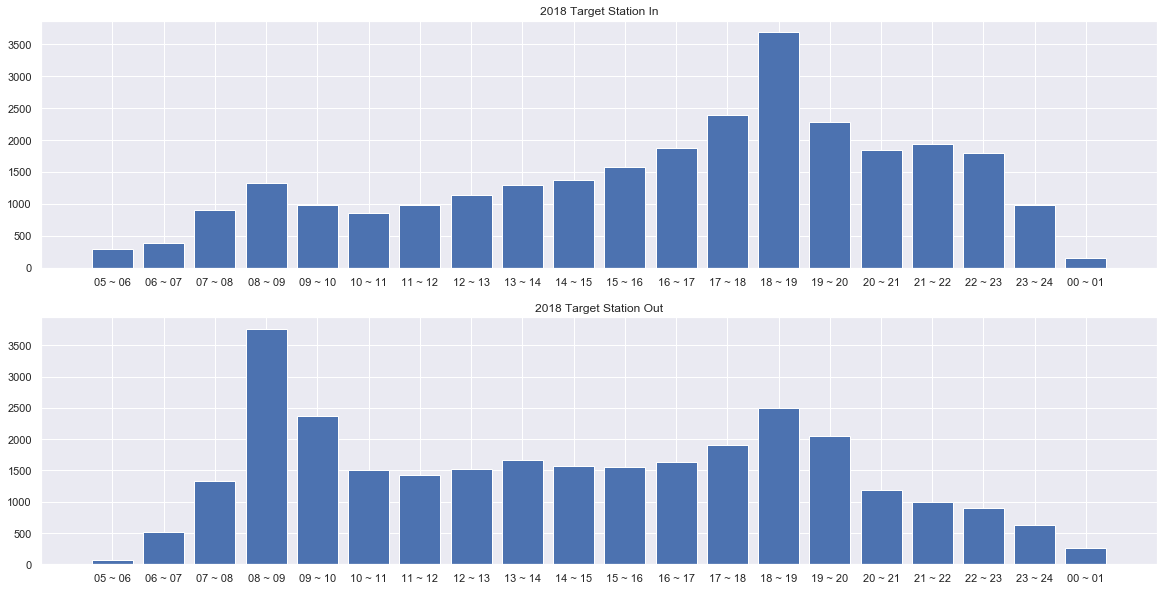

In [64]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(20,10))

axes[0].bar(target_mean_in.index, target_mean_in.values)
axes[0].set_title("2018 Target Station In")
axes[1].bar(target_mean_out.index, target_mean_out.values)
axes[1].set_title("2018 Target Station Out")

- 퇴근시간에(18 ~ 19) 승차자 수가 가장 많고 / 출근시간에(08 ~ 09) 하차자 수가 가장 많다.

## 2017년

In [ ]:
subway_2017 = subway_2017.rename(columns=subway_2017.iloc[0])
subway_2017 = subway_2017.drop(0)

subway_2017['날짜'] = subway_2017['날짜'].apply(lambda x: str(x).split()[0])
target_df_included = subway_2017[[x in target_station for x in subway_2017['역명']]]
target_df_included = target_df_included[target_df_included['호선'] == '2호선']
columns = target_df_included.columns[6:-1]
target_mean_in = target_df_included[target_df_included['구분'] == '승차'][columns].mean()
target_mean_out = target_df_included[target_df_included['구분'] == '하차'][columns].mean()

fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(20,10))

axes[0].bar(target_mean_in.index, target_mean_in.values)
axes[0].set_title("2018 Target Station In")
axes[1].bar(target_mean_out.index, target_mean_out.values)
axes[1].set_title("2018 Target Station Out")

In [18]:
graph_target = target_df_included[target_df_included['구분'] == '승차'][['역명','07 ~ 08','08 ~ 09','09 ~ 10']].groupby('역명').sum()

In [19]:
graph = pd.DataFrame(graph_target.sum(axis = 1))

In [20]:
graph = graph.rename(columns={0 : 'sum'})

In [21]:
graph = graph.reset_index()

In [22]:
column_number = {}
for i, column in enumerate(target_station):
    column_number[column] = i
    
def to_number(x, dic):
    return dic[x]

graph['역명'] = graph['역명'].apply(lambda x: to_number(x, column_number))

In [23]:
graph

,역명,sum
0,17,2977798
1,10,528915
2,15,997572
3,12,1664930
4,16,1099779
5,6,333783
6,11,1246114
7,2,1748637
8,4,1095589
9,8,390456


<BarContainer object of 16 artists>

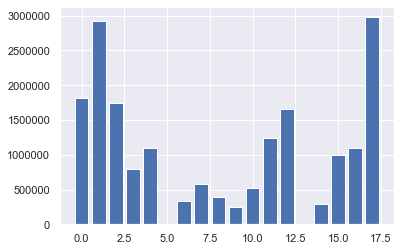

In [24]:
plt.bar(graph['역명'], graph['sum'])

- target(y) : 18 ~ 20 퇴근시간의 target_station list의 승하차 예측
- X : 출근 시간 및